<a href="https://colab.research.google.com/github/Muhammad-Ibrahim-Khan/Conditional-WGAN-GP/blob/main/Colab_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional WGAN with Gradient Penalty

### From scratch implementation from research papers demonstrated on MNIST dataset.

Wasserstein GANs offer much needed stability in training Generative Adversarial Networks (GAN). The Wasserstein distance (Earth Mover’s distance) is a distance metric between two probability distributions on a given metric space. In other words, it is the minimum amount of work needed to transform one distribution to another where work is defined as the product of mass of the distribution that has to be moved and the distance to be moved.
The advantages of using Wasserstein distance are:
- Wasserstein Distance is continuous and almost differentiable everywhere, which allows us to train the model to optimality.
- Wasserstein distance is a meaningful metric, i.e, it converges to 0 as the distributions get close to each other and diverges as they get farther away and so gives meaning to our loss metric.
- The difference between the Discriminator, which is used in the original GAN architecture and the Critic is that the discriminator is trained to correctly discriminate between the samples from Data Distribution(P_r) and of those from Model Distribution(P_g) while the Critic estimates the Wasserstein distance between P_r and P_g.
- Consequently, the generator in GAN is trained so that it succeeds in fooling the discriminator whereas in WGAN it tries to minimize the Wasserstein distance between P_r and P_g.

The Gradient Penalty constraint does considerably better than the clipping method described in the original WGAN paper in terms of optimization and convergence.

A conditional GAN (cGAN) is very similar to a regular
GAN. In its simplest form, some extra information y(labels in our case) is
concatenated onto z such that the generator is conditioned
to include this information in the generation process. In a
similar fashion, this information y is also included in the
input to the discriminator

Link for WGAN-GP paper:
> https://arxiv.org/abs/1704.00028

Link for Conditional WGAN-GP paper:
> https://cameronfabbri.github.io/papers/conditionalWGAN.pdf

## Imports


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

## Generator Model

The attribute vector y(labels) is concatenated
onto z(our input noise), which is projected into a convolutional representation of size 4×4×512 (this can be thought of as a fully connected layer without an activation function). The rest of network is fully convolutional, and contains batch normalization and a ReLU activation function after each convolution, with an exception of the output layer, which does not use batch norm and uses a TanH activation function. Each convolutional layer uses a kernel size of 5×5 and stride 2×2. For upsampling we chose to use transpose convolutions.


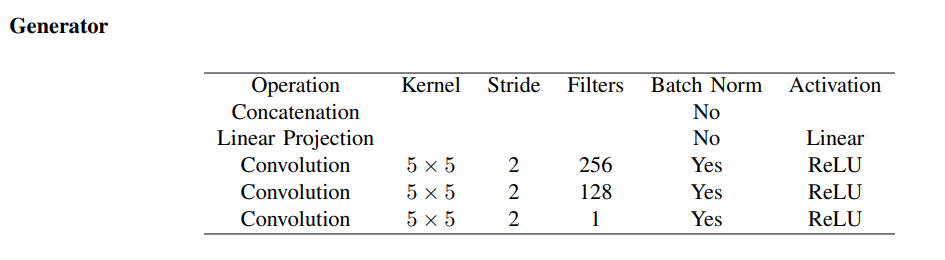

In [ ]:
class Generator(nn.Module):
    def __init__(self, channels_noise, channels_img, features_g, num_classes, img_size, embed_size):
        super(Generator, self).__init__()
        self.img_size = img_size
        self.gen = nn.Sequential(
            self._block(channels_noise + embed_size, features_g * 16, 4, 1, 0),
            self._block(features_g * 16, features_g * 8, 4, 2, 1), 
            self._block(features_g * 8, features_g * 4, 4, 2, 1),  
            self._block(features_g * 4, features_g * 2, 4, 2, 1),  
            nn.ConvTranspose2d(
                features_g * 2,
                channels_img,
                kernel_size = (4, 4),
                stride= (2, 2),
                padding= (1, 1)
            ),
            nn.Tanh()  # Normalize output to [-1, 1]
        )
        self.embed = nn.Embedding(num_classes, embed_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).unsqueeze(2).unsqueeze(3)
        x = torch.cat([x, embedding], dim=1)
        return self.gen(x)


## Critic Model

The discriminator(critic) network mostly mirrors the generator network with a few exceptions. Due to the gradient penalty with respect to the input, no batch normalization is used. Leaky ReLU activations are used after each layer, except the output which does not have an activation function. Each convolutional layer uses stride a kernel size of 5×5 and stride 2 × 2, except for the last layer which uses a kernel size of 4 × 4 and stride 1 × 1. The resulting output score from the discriminator is of size 4×4×1, which we take the mean of. In order to include the d dimensional attribute vector, we concatenate it onto the channel axis of the input image. The resulting input to the first convolutional layer is then 'm x n x (d + 3)', where m is the image height, n is the image width, and d is the number of attributes in consideration. Images are normalized to a range [−1, 1].

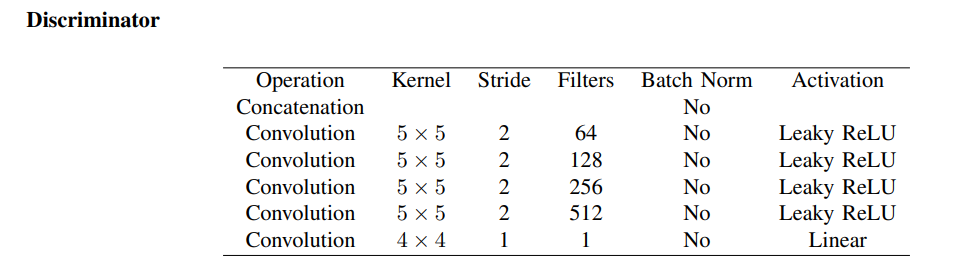

In [ ]:

class Critic(nn.Module):
    def __init__(self, channels_img, features_d, num_classes, img_size):
        super(Critic, self).__init__()
        self.img_size = img_size
        self.disc = nn.Sequential(
            nn.Conv2d(
                channels_img + 1,
                features_d,
                kernel_size = (4, 4),
                stride = (2, 2),
                padding = 1
            ),  
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d * 2, 4, 2, 1),  
            self._block(features_d * 2, features_d * 4, 4, 2, 1),  
            self._block(features_d * 4, features_d * 8, 4, 2, 1),  
            nn.Conv2d(
                features_d * 8,
                1,
                kernel_size=(4, 4),
                stride=(2, 2),
                padding=0
            ),  
        )
        self.embed = nn.Embedding(num_classes, img_size * img_size)

    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.InstanceNorm2d(out_channels, affine=True),  # LayerNorm <--->
            nn.LeakyReLU(0.2)
        )

    def forward(self, x, labels):
        embedding = self.embed(labels).view(labels.shape[0], 1, self.img_size, self.img_size)
        x = torch.cat([x, embedding], dim=1)  # N x C x img_size(H) x img_size(W)
        return self.disc(x)


## Helper functions


### Gradient Penalty

In the original WGAN paper, gradient clipping was suggested where everytime a gradient scalar went above or below a certain constant 'c' it would be assigned c.

In Gradient penalty, instead of clipping gradients we define a constraint on the gradient norm of the critic to enforce Lipshitz continuity. The idea of Gradient Penalty is to enforce a constraint such that the gradients of the critic’s output w.r.t the inputs to have unit norm.

Gradient penalty has advantages over the original clipping method suggested in the WGAN paper because:

- Capacity Underuse: While using only clipping as our constraint, the critic function only learnt very simple functions while it failed to map complex ones.
- Exploding and Vanishing Gradients: The interaction between the weight constraint and the loss function makes training of WGAN difficult and leads to exploding or vanishing gradients. For different clipping values, the gradients would almost always be pushed to the extreme values in most cases whereas in Gradient Penalty this is not the case.

> Note: The critic loss function defined in the paper has been explained so consult that for more information.

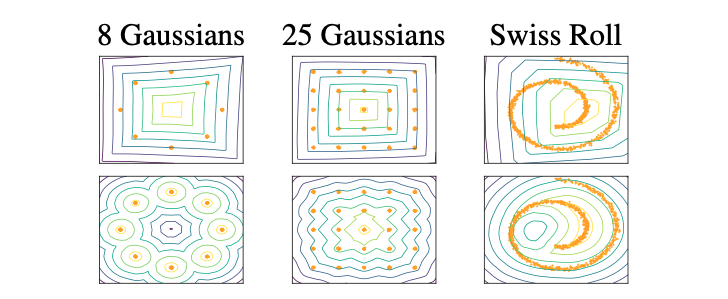

> Value surfaces learnt by WGAN critic (top) with gradient clipping, (bottom) with gradient penalty.

In [ ]:
def gradient_penalty(critic, labels, real, fake, device='cpu'):
    BATCH_SIZE, C, H, W = real.shape

    # We sample alpha from uniform distribution
    alpha = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    
    # Interpolation between fake data and real data
    interpolated_images = real * alpha + fake * (1 - alpha)

    # Calculate Critic Scores
    mixed_scores = critic(interpolated_images, labels)

    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs = torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True
    )[0]

    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    grad_penalty = torch.mean((gradient_norm - 1) ** 2)

    return grad_penalty


### Initialize Weights

This class draws values from a normal distribution of Mean 0 and Standard Deviation of 0.2 to initialize the weights of all layers in a class instead of using random initialization.

In [ ]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## Hyperparameters

Kindly refer to the WGAN-GP paper for more intuition as to why these hyperparameters were selected.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
IMG_SIZE = 64
CHANNELS_IMG = 1
NUM_CLASSES = 10
GEN_EMBEDDING = 100
Z_DIM = 100  # Dimensions of our input noise(to our generator function)
NUM_EPOCHS = 5
FEATURES_DISC = 64
FEATURES_GEN = 64
CRTIC_ITERATIONS = 5
LAMBDA_GP = 10  # Penalty Co-efficient set by authors
ADAM_BETA = (0.0, 0.9)

## Training Variables


In [ ]:
transforms = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        )
    ]
)

dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

# Creating class variables
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN, NUM_CLASSES, IMG_SIZE, GEN_EMBEDDING).to(device)
critic = Critic(CHANNELS_IMG, FEATURES_DISC, NUM_CLASSES, IMG_SIZE).to(device)

# Initializing weights of our functions (Generator and Critic)
initialize_weights(gen)
initialize_weights(critic)

# Creating seperate optimizers since the parameters of each function are different.
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=ADAM_BETA)
opt_critic = optim.Adam(critic.parameters(), lr=LEARNING_RATE, betas=ADAM_BETA)

# For Tensorboard
writer_real = SummaryWriter(f"logs/real")
writer_fake = SummaryWriter(f"logs/fake")
step = 0

gen.train()
critic.train()

## Training Module

- Since our generator relies on a perfect critic, for this reason we update the gradients of the critic n times for every 1 update to our generator (n = 5 is common practice).
The reason for this is that in the original GAN, the updates to the generator would worsen as the discriminator got better. This provides stability at the cost of longer training time.

In [ ]:
for epoch in range(NUM_EPOCHS):
    for batch_idx, (real, labels) in enumerate(loader):
        real = real.to(device)
        cur_batch_size = real.shape[0]
        labels = labels.to(device)

        for _ in range(CRTIC_ITERATIONS):
            noise = torch.randn((cur_batch_size, Z_DIM, 1, 1)).to(device)
            fake = gen(noise, labels)
            critic_real = critic(real, labels).reshape(-1)
            critic_fake = critic(fake, labels).reshape(-1)
            gp = gradient_penalty(critic, labels, real, fake, device=device)

            # Train Critic
            loss_critic = (
                -(torch.mean(critic_real) - torch.mean(critic_fake)) + LAMBDA_GP * gp
            )

            critic.zero_grad()
            loss_critic.backward(retain_graph=True)
            opt_critic.step()

        # Train Generator
        gen_fake = critic(fake, labels).reshape(-1)
        loss_gen = -torch.mean(gen_fake)
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        # Print losses occasionally and print to tensorboard
        if batch_idx % 100 == 0:
            print(
                f"Epoch [{epoch}/{NUM_EPOCHS}] Batch {batch_idx}/{len(loader)} \
                 Loss c: {loss_critic:.4f}, loss G: {loss_gen:.4f}"

            )

            with torch.no_grad():
                # We generate fake images by feeding noise and labels to our generator.
                fake = gen(noise, labels)

                # Take out the first 32 examples from current batch.
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )

                # Saving our losses to logs.
                writer_real.add_scalar("Loss of Critic.", loss_critic, global_step = step)
                writer_fake.add_scalar("Loss of Generator.", loss_gen, global_step = step)

                writer_real.add_image("Real.", img_grid_real, global_step=step)
                writer_fake.add_image("Generated.", img_grid_fake, global_step=step)

            step += 1

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw

Epoch [0/5] Batch 0/938                  Loss c: -13.0354, loss G: 10.9558
Epoch [0/5] Batch 100/938                  Loss c: -148.7439, loss G: 139.9413
Epoch [0/5] Batch 200/938                  Loss c: -102.5040, loss G: 121.0660
Epoch [0/5] Batch 300/938                  Loss c: -60.3841, loss G: 100.1159
Epoch [0/5] Batch 400/938                  Loss c: -36.9003, loss G: 107.1205
Epoch [0/5] Batch 500/938                  Loss c: -27.8300, loss G: 105.4182
Epoch [0/5] Batch 600/938                  Loss c: -20.4145, loss G: 103.2784
Epoch [0/5] Batch 700/938                  Loss c: -16.7999, loss G: 85.9469
Epoch [0/5] Batch 800/938                  Loss c: -17.5008, loss G: 97.3965
Epoch [0/5] Batch 900/938                  Loss c: -11.4142, loss G: 96.2131
Epoch [1/5] Batch 0/938                  Loss c: -9.2388, loss G: 96.3933
Epoch [1/5] Batch 100/938                  Loss c: -9.9304, loss G: 93.30

## Results

### Losses

#### For Critic
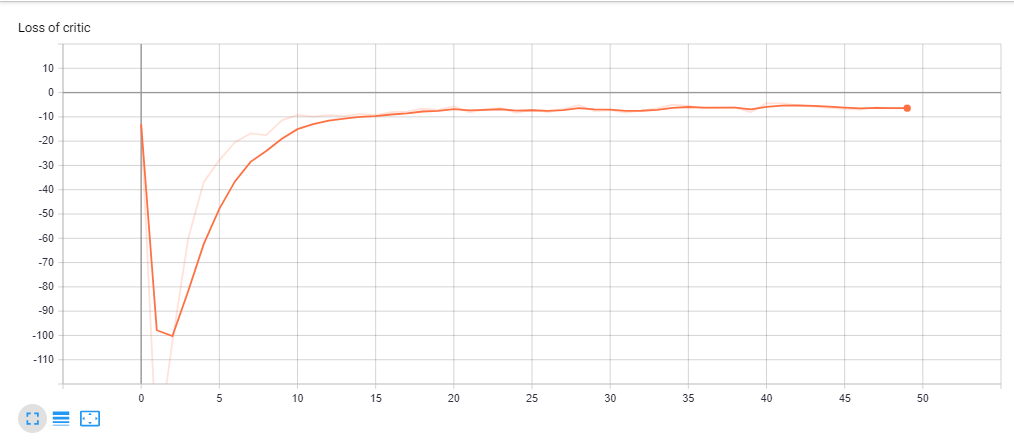

#### For Generator

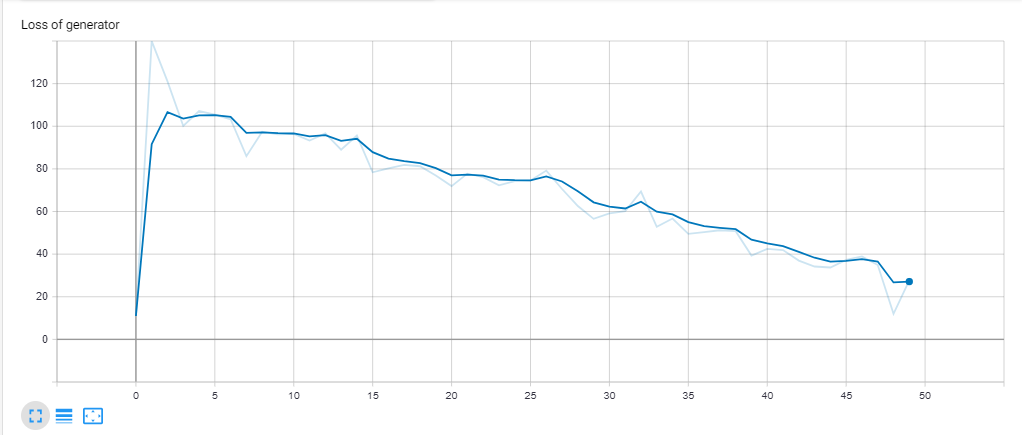

### Images

#### Actual Images

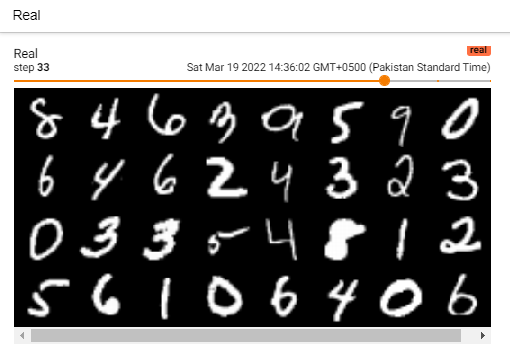

#### Generated Images

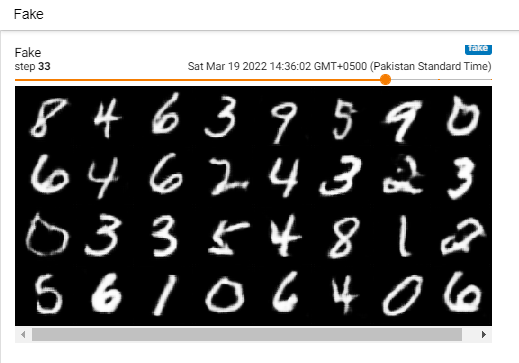

## Conclusions

The results show a stable generative method for image generation conditioned on attributes. In comparison to the vanilla GAN loss, WGAN-GP offers a more stable training environment as well as higher quality samples. The loss computed by WGAN-GP is also overall smoother, and suffers less from mode collapse. Despite the longer training time, its improvements are very advantageous in other applications.

## Acknowledgments

- https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490

- https://towardsdatascience.com/demystified-wasserstein-gans-wgan-f835324899f4